# Taiki wrote the wrong name, actually TOI5648.01

https://docs.google.com/spreadsheets/d/1f5wdZhwy0w1F0w0b89udEsZmvkBVsSTSK8Qh7XU2wOM/edit#gid=617880947

## MuSCAT3 TFOP template
* update [TFOP spreadsheet](https://docs.google.com/spreadsheets/d/1f5wdZhwy0w1F0w0b89udEsZmvkBVsSTSK8Qh7XU2wOM/edit#gid=617880947)

RECENT CHANGES in this notebook:
* create movie (gif)
* auto_apphot_{mapping/centroid}.pl is parallelized!
* auto_mklc.pl is parallelized!
  - all cID combination

In [1]:
import os
from pathlib import Path
from itertools import combinations
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle
from IPython import display 
import astropy.io.fits as fits
from astropy.visualization import ZScaleInterval, ImageNormalize

from tqdm import tqdm
import astropy.units as u
from astropy.wcs import WCS

os.umask(0o002) # to make output (e.g. csv) writable by user/group
os.nice(19)     # high nice number, lower execution priority

inst='muscat3'
date= '220630'         # yymmdd
base_dir=%pwd

cam_codes = {
    'r': 'ep02',
    'i': 'ep03',
    'g': 'ep04',
    'z': 'ep05'
}
cam_names = ['ep02', 'ep03', 'ep04', 'ep05'] 
ccds = [0, 1, 2, 3]
nccd = len(ccds)

inst_dir = f'/ut3/muscat/reduction_afphot/{inst}'
os.chdir(inst_dir)

In [2]:
from urllib.request import urlopen
import json

target = "TOI-5671.01"
url = f"https://exofop.ipac.caltech.edu/tess/target.php?id={target}&json"
response = urlopen(url)
data_json = json.loads(response.read())
data_json['coordinates']

{'ra': '211.009219627329',
 'dec': '+38.618330983651603',
 'galactic_long': '74.64171',
 'galactic_lat': '70.97229',
 'ecliptic_long': '190.2457',
 'ecliptic_lat': '47.11664',
 'pm_ra': '-44.6441',
 'pm_ra_error': '.0534319',
 'pm_dec': '15.0831',
 'pm_dec_error': '.0718341'}

In [3]:
ra  = float(data_json['coordinates']['ra'])      # target coord in deg
dec = float(data_json['coordinates']['dec'])       # target coord in deg
ra, dec

(211.009219627329, 38.6183309836516)

In [4]:
## Showing obslog
for i in range(nccd):
    print('\n=== {0} ==='.format(cam_names[i]))
    !perl /ut3/muscat/obslog/show_obslog_summary.pl $inst 220630 $i


=== ep02 ===
# OBJECT EXPTIME(s) READ_MODE FRAME#1 FRAME#2 UT-STRT1 UT-STRT2 NFRAMES
TOI5648        50.000 MUSCAT_FAST 0057 0289 06:04:30 09:39:02  233
TOI5648        50.000 MUSCAT_FAST 0291 0307 09:40:52 09:55:44   17

=== ep03 ===
# OBJECT EXPTIME(s) READ_MODE FRAME#1 FRAME#2 UT-STRT1 UT-STRT2 NFRAMES
TOI5648        30.000 MUSCAT_FAST 0056 0447 06:04:30 09:56:22  392

=== ep04 ===
# OBJECT EXPTIME(s) READ_MODE FRAME#1 FRAME#2 UT-STRT1 UT-STRT2 NFRAMES
TOI5648        110.000 MUSCAT_FAST 0056 0164 06:04:30 09:31:29  109
TOI5648        110.000 MUSCAT_FAST 0166 0176 09:35:19 09:54:32   11

=== ep05 ===
# OBJECT EXPTIME(s) READ_MODE FRAME#1 FRAME#2 UT-STRT1 UT-STRT2 NFRAMES
TOI5648        50.000 MUSCAT_FAST 0056 0316 06:04:30 09:55:58  261


In [5]:
#======
frameID1 = [57, 56, 56, 56]  # the first frame IDs for ep01, ep02, ep03, and ep04
frameID2 = [307, 447, 176, 316]  # the last frame IDs for ep01, ep02, ep03, and ep04
#======

In [6]:
s=0
for i in range(4):
    d = frameID2[i]-frameID1[i]
    print(d)
    s+=d
print("Total:", s)

250
391
120
260
Total: 1021


## Create movie per band

In [7]:
from pathlib import Path
from astropy.visualization import ZScaleInterval
from astropy.wcs import WCS
import matplotlib.pyplot as pl

dict_fits_list = {}
for n,(b, cam_code) in enumerate(cam_codes.items()):
    telcode = f"ogg2m001-{cam_code}"
    p = Path(f"/data/MuSCAT3/{date}")
    
    fits_list = p.glob(f"{telcode}*.fits")
    fits_list_chunk = []
    for f in fits_list:
        frameno = int(str(f).split('-')[3])
        if (frameno>=frameID1[n]) & (frameno<=frameID2[n]):
            fits_list_chunk.append(f)
    dict_fits_list[b] = list(sorted(fits_list_chunk))
    print(f"{b}: {len(fits_list_chunk)}")

r: 250
i: 392
g: 120
z: 261


Set OBSGEO-B to    20.706900 from OBSGEO-[XYZ].
Set OBSGEO-H to     3047.597 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


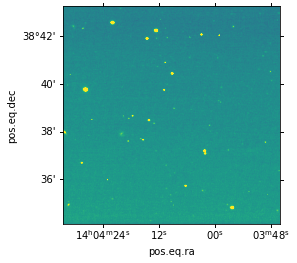

In [8]:
#======
b = 'g' # choose which band to create movie
fits_list = dict_fits_list[b]
skip = 10 # skip every frame
#======

#read data and header in each frame above
data = {}
header = {}

for f in fits_list[::skip]:
    n = str(f).split('-')[-2]
    d = fits.getdata(f)
    h = fits.getheader(f)
    data[n] = d
    header[n] = h
    
wcs = WCS(h)
zint = ZScaleInterval(contrast=0.5)
zmin,zmax = zint.get_limits(d)

fig = pl.figure()
ax = fig.add_subplot(projection=wcs)
ax.imshow(d, vmin=zmin, vmax=zmax, origin="lower");

In [9]:
#show and save movie
#make a dictionary of fits list per band
dict_fits_list = {}
for b, cam_code in cam_codes.items():
    telcode = f"ogg2m001-{cam_code}"
    p = Path(f"/data/MuSCAT3/{date}")
    fits_list = p.glob(f"{telcode}*.fits")
    dict_fits_list[b] = list(sorted(fits_list))
    
#show frames to use in movie
fits_list = dict_fits_list[b][::skip]
# fits_list

    
fig, ax = plt.subplots(figsize=(8,8))

frames = []
for n in list(data.keys()):
    h = header[n]
    d = data[n]    
    telcode = f"ogg2m001-{cam_codes[b]}"
    ax.set_title(f"MuSCAT3{b} ({telcode})", fontsize=18)
    
    norm = ImageNormalize(d, interval=ZScaleInterval())
    img = ax.imshow(d, norm=norm, animated=True)
    
    frames.append([img])
    
    
ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
                                repeat_delay=1000)
html = display.HTML(ani.to_jshtml())
display.display(html)
output = f'{base_dir}/{target}_{inst}_{date}_movie.gif'
ani.save(output)
print("Saved: ", output)
plt.close()

Saved:  /raid_ut3/home/muscat/reduction_afphot/notebooks/TFOP/muscat3/TOI5671.01/TOI-5671.01_muscat3_220630_movie.gif


In [18]:
## preparing target directries and object lists

data_dir = f'/data/MuSCAT3/{date}'

date_dir = os.path.join(inst_dir, date)
if not os.path.exists(date_dir):
    os.mkdir(date_dir)
    
target_dir = os.path.join(date_dir, target)
if not os.path.exists(target_dir):
    os.mkdir(target_dir)
list_dir = os.path.join(target_dir, 'list')
if not os.path.exists(list_dir):
    os.mkdir(list_dir)
    
param_def = os.path.join(inst_dir, 'params/param_muscat3')
param_dir = os.path.join(target_dir, 'param')
if not os.path.exists(param_dir):
    !cp -r $param_def $param_dir

df_dir = os.path.join(target_dir, 'df')
if not os.path.exists(df_dir):
    !ln -s $data_dir $df_dir

for i in range(nccd):
    ccd = ccds[i]
    target_dir_ccd = os.path.join(date_dir, target+'_{0}'.format(ccd))
    if not os.path.exists(target_dir_ccd):
        os.mkdir(target_dir_ccd)
           
    param_def = os.path.join(inst_dir, 'params/param_muscat3')
    param_dir = os.path.join(target_dir_ccd, 'param')
    if not os.path.exists(param_dir):
        !cp -r $param_def $param_dir

    df_dir = os.path.join(target_dir_ccd, 'df')
    if not os.path.exists(df_dir):
        !ln -s $data_dir $df_dir
            
    list_dir = os.path.join(target_dir_ccd, 'list')
    if not os.path.exists(list_dir):
        os.mkdir(list_dir)

    obj_list = os.path.join(list_dir, 'object_ccd{0}.lst'.format(ccd))
    
    ids = np.arange(frameID1[i],frameID2[i]+1,step=1)
    fits_list = ['ogg2m001-{0}-20{1}-{2:04d}-e91.fits'.format(cam_names[i],date,id) for id in (ids)]
    with open(obj_list, mode='w') as f:
        f.write('\n'.join(fits_list))

## Create a reference image

In [39]:
cat param/param-starfind_centroid.par

# Parameters for starfind_centroid
# 
apradius 20
threshold 50 
apPixmin 10
apADUmin 10000

subframe0 0 2048 0 2048


set `threshold=5` and `apradius=10` to detect the faint target which is also very close to TOI 5648 (retired)

In [44]:
#======
ref_ep=2                # ep2='r'; ep3='i'; ep4='g'; ep5='z' band
refid=frameID1[0]       # optional (default=[ID of the first frame])
#======

ref_file = 'ogg2m001-ep0{0}-20{1}-{2:04d}-e91.fits'.format(ref_ep,date,refid)
print('reference frame: ', ref_file)

ref_list = 'list/ref.lst'
os.chdir(target_dir)
with open(ref_list, mode='w') as f:
    f.write(ref_file)
    
!starfind_centroid.pl $ref_list > /dev/null
!mkreference.pl $ref_list

refframe = ref_file.replace('.fits','')
ref_dir = os.path.join(target_dir, 'reference')
ref_obj_file = os.path.join(ref_dir, 'ref-' + refframe + '.objects')

!cat $ref_obj_file

reference frame:  ogg2m001-ep02-20220630-0057-e91.fits
cp df/ogg2m001-ep02-20220630-0057-e91.fits ./reference/ref-ogg2m001-ep02-20220630-0057-e91.fits
cp ./objects/ogg2m001-ep02-20220630-0057-e91.objects ./reference/ref-ogg2m001-ep02-20220630-0057-e91.objects
# ./df/ogg2m001-ep02-20220630-0057-e91.fits 2048 2048
# dark = 0
# median sky = 213.498
# noise = 18.9076
# threshold  = 5
# hmin  = 94.5381
# ADU range -1000 130000
# apradius = 10
# apADUmin = 10000
# apPixmin = 10
# Subframe 0 2048 0 2048
# Find on 10 2037 10 2037
       1      216.080     1252.252      216.000     1252.000  1051319.750    18281.318
       2      466.998     1883.040      467.000     1883.000   603822.000    11059.937
       3      875.407     1810.922      875.000     1811.000   464943.062     8795.129
       4     1596.478      148.633     1597.000      149.000   276736.656     5249.905
       5      790.875     1735.663      791.000     1736.000   232303.641     4577.411
       6     1335.989      681.818   

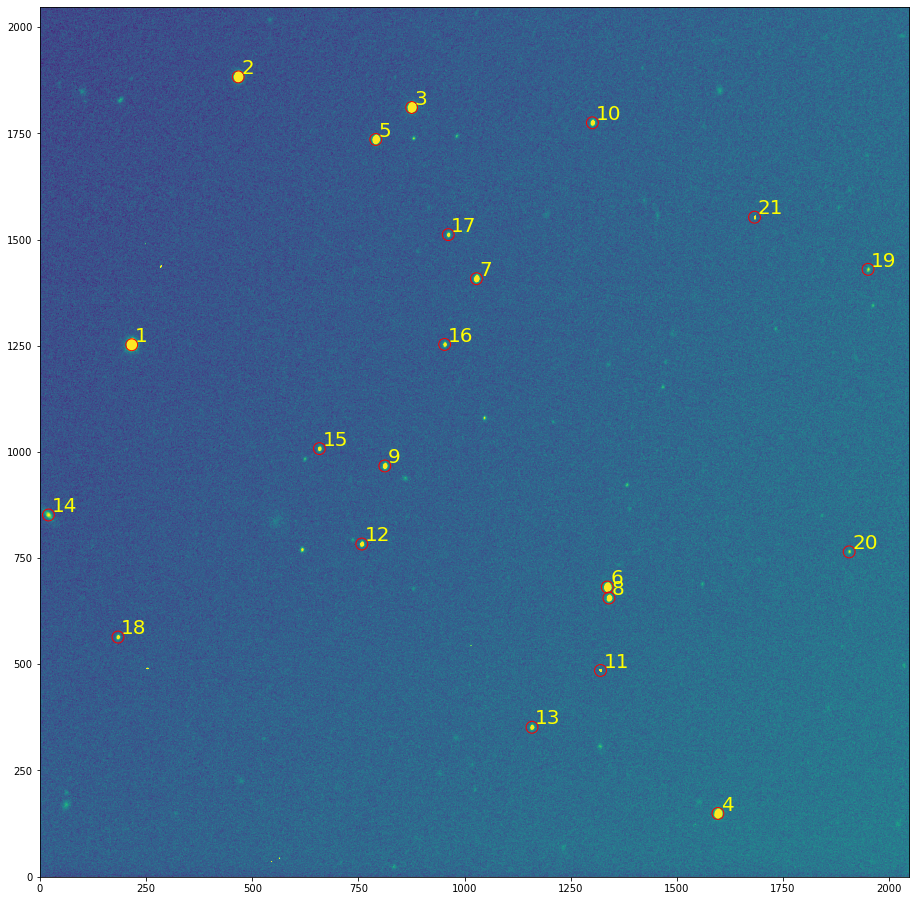

In [45]:
## Showing reference image

refxy = np.genfromtxt(ref_obj_file, delimiter=13, usecols=(1,2))

ref_fits = os.path.join(target_dir,  'reference/ref-' + refframe + '.fits')
d = fits.getdata(ref_fits)
h = fits.getheader(ref_fits)

norm = ImageNormalize(d, interval=ZScaleInterval())
plt.figure(figsize=(16,16))
ax=plt.subplot(1,1,1)
plt.imshow(d, origin='lower', norm=norm)
rad=14
for i in range(len(refxy)):
    circ = plt.Circle(refxy[i], rad, color='red', fill=False)
    ax.add_patch(circ)
    plt.text(refxy[i][0]+rad/2., refxy[i][1]+rad/2., str(i+1), fontsize=20, color='yellow')

## show FOV, zoom in target, and FWHM

In [50]:
#===========
rad_arcsec = 210  #radius of the cropped/ zoom to target

#visualize a sample minimum and maximum phot radius
r1, r2 = 8, 20  # pix
#===========

Set OBSGEO-B to    20.706900 from OBSGEO-[XYZ].
Set OBSGEO-H to     3047.597 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


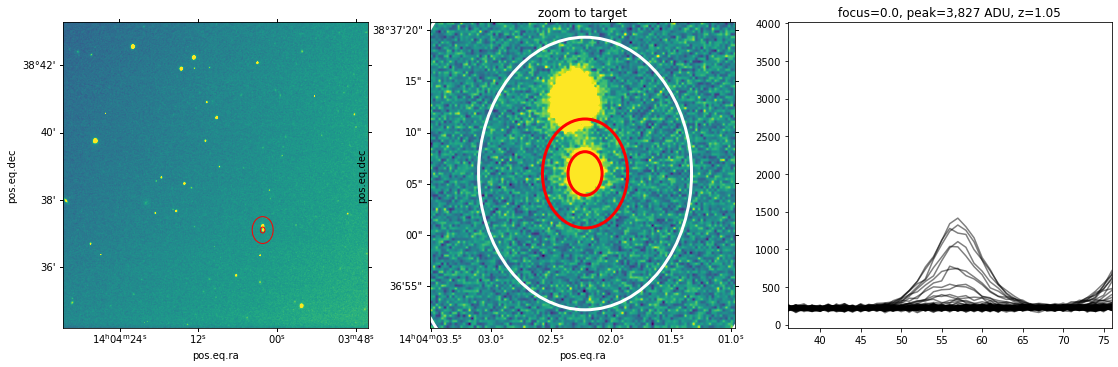

In [51]:
wcs = WCS(h)
coords = wcs.all_world2pix(np.c_[ra,dec], 0)
xpix, ypix = int(coords[0][0]), int(coords[0][1])

dx = dy = round(rad_arcsec*h['PIXSCALE'])

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131, projection=wcs)
ax.imshow(d, norm=ImageNormalize(d, interval=ZScaleInterval(contrast=0.5)), origin="lower")


#show sky annulus positon around target
sky_sep = 50    
sky_wid = 40
for r in [r2,sky_sep+sky_wid]:
    c = Circle((ra, dec), r*h['PIXSCALE']/3600, edgecolor='r', facecolor='none', lw=1,
                  transform=ax.get_transform('fk5'))
    ax.add_patch(c)

dcrop = d[ypix-dy:ypix+dy,xpix-dx:xpix+dx]
wcscrop = wcs[ypix-dy:ypix+dy,xpix-dx:xpix+dx]

ax = fig.add_subplot(132, projection=wcscrop)
ax.imshow(dcrop, norm=ImageNormalize(dcrop, interval=ZScaleInterval(contrast=0.5)))
#aperture min & max
for r in [r1,r2]:
    c = Circle((ra, dec), r*h['PIXSCALE']/3600, edgecolor='r', facecolor='none', lw=3,
                  transform=ax.get_transform('fk5'))
    ax.add_patch(c)
#sky
for r in [sky_sep,sky_sep+sky_wid]:
    c = Circle((ra, dec), r*h['PIXSCALE']/3600, edgecolor='w', facecolor='none', lw=3,
                  transform=ax.get_transform('fk5'))
    ax.add_patch(c)
ax.set_title("zoom to target")

ax = fig.add_subplot(133)
half = dcrop.shape[0]//2
# ax.plot(dcrop[half,:], 'r', lw=3, zorder=10)
ax.plot(dcrop, 'k', alpha=0.5)
ax.set_xlim(half-r2, half+r2)

idx = np.unravel_index(dcrop.argmax(), dcrop.shape)
peak = round(dcrop[idx])
ax.set_title(f"focus={h['FOCOBOFF']}, peak={peak:,} ADU, z={h['AIRMASS']:.2f}")
fig.tight_layout()

## Set-up apphot script parameters

In [53]:
# Change the following values
#========
tID = 8     # Target ID
nstars = 10 # number of stars (from the brightest star) to be measured
rad1 = 8   # mininmum aperture radius in pixel
rad2 = 20   # maximum aperture radius in pixel
drad = 2    # step size of aperture radius in pixel
method = 'mapping'  # method to calculate aperture centroids (mapping or centroid)
#========

if method=='mapping':
    script = 'scripts/auto_apphot_mapping.pl'  
elif method=='centroid':
    script = 'scripts/auto_apphot_centroid.pl'

## list apphot arguments

In [54]:
def run_apphot(arg):
    # Run the script with the given argument
    command = f"perl {script} {arg}"
    exit_status = os.system(command)
        
    # Check the exit status
    if exit_status == 0:
        print(f"{arg} done.\n")
    else:
        print(f"There was an error running the {script} {arg}\n")

# Create a list of arguments to pass to the script
apphot_args = []
for ccd in ccds:
    for rad in np.arange(rad1,rad2+drad,drad):
        arg = f"{date} {target} {ccd} {nstars} {rad} {rad} {drad}"
        apphot_args.append(arg)
len(apphot_args)

28

In [55]:
apphot_args

['220630 TOI-5671.01 0 10 8 8 2',
 '220630 TOI-5671.01 0 10 10 10 2',
 '220630 TOI-5671.01 0 10 12 12 2',
 '220630 TOI-5671.01 0 10 14 14 2',
 '220630 TOI-5671.01 0 10 16 16 2',
 '220630 TOI-5671.01 0 10 18 18 2',
 '220630 TOI-5671.01 0 10 20 20 2',
 '220630 TOI-5671.01 1 10 8 8 2',
 '220630 TOI-5671.01 1 10 10 10 2',
 '220630 TOI-5671.01 1 10 12 12 2',
 '220630 TOI-5671.01 1 10 14 14 2',
 '220630 TOI-5671.01 1 10 16 16 2',
 '220630 TOI-5671.01 1 10 18 18 2',
 '220630 TOI-5671.01 1 10 20 20 2',
 '220630 TOI-5671.01 2 10 8 8 2',
 '220630 TOI-5671.01 2 10 10 10 2',
 '220630 TOI-5671.01 2 10 12 12 2',
 '220630 TOI-5671.01 2 10 14 14 2',
 '220630 TOI-5671.01 2 10 16 16 2',
 '220630 TOI-5671.01 2 10 18 18 2',
 '220630 TOI-5671.01 2 10 20 20 2',
 '220630 TOI-5671.01 3 10 8 8 2',
 '220630 TOI-5671.01 3 10 10 10 2',
 '220630 TOI-5671.01 3 10 12 12 2',
 '220630 TOI-5671.01 3 10 14 14 2',
 '220630 TOI-5671.01 3 10 16 16 2',
 '220630 TOI-5671.01 3 10 18 18 2',
 '220630 TOI-5671.01 3 10 20 20 2']

## Run apphot all bands in parallel

In [56]:
%%time

# Create a pool of worker processes
os.chdir(inst_dir)

#=============
#the number of concurrent photometry run for a given ccd and aperture radius
njobs = 10
#=============

print(f'>> Performing aperture photometry...\n')
with Pool(njobs) as p:
    # Apply the run_script function to each element in the args_list in parallel
    p.map(run_apphot, apphot_args)

>> Performing aperture photometry...

220630 TOI-5671.01 0 10 16 16 2 done.
220630 TOI-5671.01 0 10 18 18 2 done.
220630 TOI-5671.01 0 10 12 12 2 done.
220630 TOI-5671.01 0 10 8 8 2 done.
220630 TOI-5671.01 0 10 10 10 2 done.
220630 TOI-5671.01 0 10 14 14 2 done.






220630 TOI-5671.01 0 10 20 20 2 done.

220630 TOI-5671.01 2 10 8 8 2 done.

220630 TOI-5671.01 2 10 10 10 2 done.

220630 TOI-5671.01 2 10 12 12 2 done.

220630 TOI-5671.01 1 10 8 8 2 done.
220630 TOI-5671.01 1 10 10 10 2 done.


220630 TOI-5671.01 1 10 12 12 2 done.

220630 TOI-5671.01 2 10 14 14 2 done.

220630 TOI-5671.01 2 10 16 16 2 done.

220630 TOI-5671.01 2 10 18 18 2 done.

220630 TOI-5671.01 2 10 20 20 2 done.

220630 TOI-5671.01 1 10 14 14 2 done.

220630 TOI-5671.01 1 10 16 16 2 done.

220630 TOI-5671.01 1 10 18 18 2 done.

220630 TOI-5671.01 1 10 20 20 2 done.

220630 TOI-5671.01 3 10 8 8 2 done.

220630 TOI-5671.01 3 10 10 10 2 done.

220630 TOI-5671.01 3 10 12 12 2 done.

220630 TOI-5671.01 3 10 14 14 2 do

## get all possible combinations of cIDs

In [57]:
from itertools import combinations

#get all cID from 1 to nstars excluding tID
selected_cIDs = [str(i) for i in range(1, nstars+1) if i!=tID]
#or specify each cID below
# selected_cIDs = ['2','3','5','6','7', '8','9','10']
assert str(tID) not in selected_cIDs

cIDs = []
for i in range(len(selected_cIDs)):
    cs = list(combinations(selected_cIDs,i+1))
    flatlist=[' '.join(j) for j in cs]
#     print(flatlist)
    cIDs.append(flatlist)
cIDs = [item for sublist in cIDs for item in sublist]
len(cIDs)

511

In [58]:
cIDs

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '9',
 '10',
 '1 2',
 '1 3',
 '1 4',
 '1 5',
 '1 6',
 '1 7',
 '1 9',
 '1 10',
 '2 3',
 '2 4',
 '2 5',
 '2 6',
 '2 7',
 '2 9',
 '2 10',
 '3 4',
 '3 5',
 '3 6',
 '3 7',
 '3 9',
 '3 10',
 '4 5',
 '4 6',
 '4 7',
 '4 9',
 '4 10',
 '5 6',
 '5 7',
 '5 9',
 '5 10',
 '6 7',
 '6 9',
 '6 10',
 '7 9',
 '7 10',
 '9 10',
 '1 2 3',
 '1 2 4',
 '1 2 5',
 '1 2 6',
 '1 2 7',
 '1 2 9',
 '1 2 10',
 '1 3 4',
 '1 3 5',
 '1 3 6',
 '1 3 7',
 '1 3 9',
 '1 3 10',
 '1 4 5',
 '1 4 6',
 '1 4 7',
 '1 4 9',
 '1 4 10',
 '1 5 6',
 '1 5 7',
 '1 5 9',
 '1 5 10',
 '1 6 7',
 '1 6 9',
 '1 6 10',
 '1 7 9',
 '1 7 10',
 '1 9 10',
 '2 3 4',
 '2 3 5',
 '2 3 6',
 '2 3 7',
 '2 3 9',
 '2 3 10',
 '2 4 5',
 '2 4 6',
 '2 4 7',
 '2 4 9',
 '2 4 10',
 '2 5 6',
 '2 5 7',
 '2 5 9',
 '2 5 10',
 '2 6 7',
 '2 6 9',
 '2 6 10',
 '2 7 9',
 '2 7 10',
 '2 9 10',
 '3 4 5',
 '3 4 6',
 '3 4 7',
 '3 4 9',
 '3 4 10',
 '3 5 6',
 '3 5 7',
 '3 5 9',
 '3 5 10',
 '3 6 7',
 '3 6 9',
 '3 6 10',
 '3 7 9',
 '3 7 10',
 '

## set-up mklc script and arguments

In [59]:
def run_mklc(arg):
    # Run the script with the given argument
    command = f"scripts/auto_mklc.pl {arg}"
    exit_status = os.system(command)
    
    # Check the exit status
    if exit_status == 0:
        print(f"{command} done.")
    else:
        print(f"There was an error running {command}")
    
mklc_args = [f"-date {date} -obj {target} -ap_type {method} -r1 {rad1} -r2 {rad2} -dr {drad} -tid {tID} -cids {cID}" for cID in cIDs]
#mklc commands
len(mklc_args)

511

In [60]:
#sample mklc args
mklc_args[0]

'-date 220630 -obj TOI-5671.01 -ap_type mapping -r1 8 -r2 20 -dr 2 -tid 8 -cids 1'

## run mklc in parallel

In [61]:
njobs = 20

with Pool(njobs) as p:
    # Apply the run_script function to each element in the args_list in parallel
    p.map(run_mklc, mklc_args)

scripts/auto_mklc.pl -date 220630 -obj TOI-5671.01 -ap_type mapping -r1 8 -r2 20 -dr 2 -tid 8 -cids 9 done.scripts/auto_mklc.pl -date 220630 -obj TOI-5671.01 -ap_type mapping -r1 8 -r2 20 -dr 2 -tid 8 -cids 1 done.scripts/auto_mklc.pl -date 220630 -obj TOI-5671.01 -ap_type mapping -r1 8 -r2 20 -dr 2 -tid 8 -cids 7 9 done.scripts/auto_mklc.pl -date 220630 -obj TOI-5671.01 -ap_type mapping -r1 8 -r2 20 -dr 2 -tid 8 -cids 1 7 done.


scripts/auto_mklc.pl -date 220630 -obj TOI-5671.01 -ap_type mapping -r1 8 -r2 20 -dr 2 -tid 8 -cids 5 6 done.scripts/auto_mklc.pl -date 220630 -obj TOI-5671.01 -ap_type mapping -r1 8 -r2 20 -dr 2 -tid 8 -cids 1 7 9 done.scripts/auto_mklc.pl -date 220630 -obj TOI-5671.01 -ap_type mapping -r1 8 -r2 20 -dr 2 -tid 8 -cids 6 7 10 done.scripts/auto_mklc.pl -date 220630 -obj TOI-5671.01 -ap_type mapping -r1 8 -r2 20 -dr 2 -tid 8 -cids 3 9 done.

scripts/auto_mklc.pl -date 220630 -obj TOI-5671.01 -ap_type mapping -r1 8 -r2 20 -dr 2 -tid 8 -cids 2 3 9 done.scripts/aut

In [62]:
#create directory where to put csv files based on apphot method
!mkdir $date/$target/$method
!mv $date/$target/*.csv $date/$target/$method/

In [63]:
#show csv files within "method" directory
!ls $date/$target/$method

lcf_muscat3_g_TOI-5671.01_220630_t8_c10_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c110_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c1210_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c12310_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c123410_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c1234510_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c12345610_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c123456710_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c1234567910_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c12345679_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c1234567_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c123456910_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c1234569_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c123456_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c12345710_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c123457910_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c1234579_r8-20.csv
lcf_muscat3_g_TOI-5671.01_220630_t8_c123457_r8-20.csv
lcf_muscat3_g_T